# Evaluation per number of interactions

In this notebook we check how evaluation metrics differs for users with a given number of interactions.

Prerequisites: metrics per user generated via evaluation-per-user notebook

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

sys.path.append("../../../src")
from common import config
from evaluator import Evaluator
import helpers

plt.rcParams["figure.figsize"] = [12, 8]

## Preparing data

In [2]:
paths = config.Paths(dataset_name="jobs_published", target_users_name="all")
evaluation_per_user_path = paths.results_evaluation_dir.parent / "evaluation_per_user" / "results.gzip"

In [3]:
%%time
# load evaluation per user
evaluation_per_user = pd.read_csv(evaluation_per_user_path, compression='gzip')

CPU times: user 3.16 s, sys: 394 ms, total: 3.56 s
Wall time: 3.57 s


In [4]:
%%time
# load interactions
from data.initializer import DataLoaderSaver

data = DataLoaderSaver()

data.load_interactions(paths.train_and_validation)

interactions = data.interactions

CPU times: user 1min 21s, sys: 12.3 s, total: 1min 33s
Wall time: 1min 34s


In [5]:
interactions_per_user = interactions.groupby("user").size().reset_index().astype(int)
interactions_per_user.columns = ["user", "nb_interactions"]

In [6]:
evaluation_per_user = pd.merge(evaluation_per_user, interactions_per_user, on="user")

In [7]:
evaluation_per_user = helpers.add_column_bin(evaluation_per_user, column="nb_interactions", nbins=10)\
    .rename(columns={"model_name": "Model", 
                    "nb_interactions_bin": "Number of interactions bin"})

In [8]:
paths = config.Paths(dataset_name="jobs_published", target_users_name="all")
output_path = paths.results_evaluation_dir.parent / "evaluation_per_user"
output_path.mkdir(parents=True, exist_ok=True)

evaluation_per_user.to_csv(output_path / "results_bins.gzip", compression='gzip', index=None)

In [9]:
evaluation_per_bin = evaluation_per_user.groupby(["Model", "Number of interactions bin"])["precision"]\
                    .mean().reset_index()

## Results

In [10]:
evaluation_per_bin.groupby(["Model", "Number of interactions bin"]).size()["als"] #the same for all models

Number of interactions bin
[1.0, 3.0)       1
[3.0, 5.0)       1
[5.0, 8.0)       1
[8.0, 11.0)      1
[11.0, 16.0)     1
[16.0, 22.0)     1
[22.0, 31.0)     1
[31.0, 45.0)     1
[45.0, 74.0)     1
[74.0, 852.0)    1
dtype: int64

In [11]:
result = evaluation_per_bin.pivot(
    index="Number of interactions bin",
    columns="Model",
    values="precision",
)
result

Model,als,lightfm,prod2vec,random,rp3beta,slim,toppop
Number of interactions bin,,,,,,,
"[1.0, 3.0)",0.025462,0.022162,0.022912,0.000017,0.031876,0.028908,0.000506
"[3.0, 5.0)",0.033127,0.028671,0.030619,0.000017,0.039925,0.034193,0.000527
"[5.0, 8.0)",0.040481,0.034070,0.036800,0.000028,0.046821,0.040843,0.000671
"[8.0, 11.0)",0.043987,0.036609,0.038557,0.000033,0.049945,0.045606,0.000771
"[11.0, 16.0)",0.045383,0.038068,0.039074,0.000040,0.050772,0.048051,0.000833
"[16.0, 22.0)",0.046603,0.038783,0.038874,0.000053,0.051266,0.050127,0.000934
"[22.0, 31.0)",0.047851,0.038974,0.039268,0.000055,0.051445,0.052027,0.001123
"[31.0, 45.0)",0.048342,0.039320,0.038893,0.000067,0.051737,0.053074,0.001574
"[45.0, 74.0)",0.049181,0.039086,0.039310,0.000084,0.052415,0.054966,0.001770


Text(0.5, 1.0, 'Precision per number of interactions used for training')

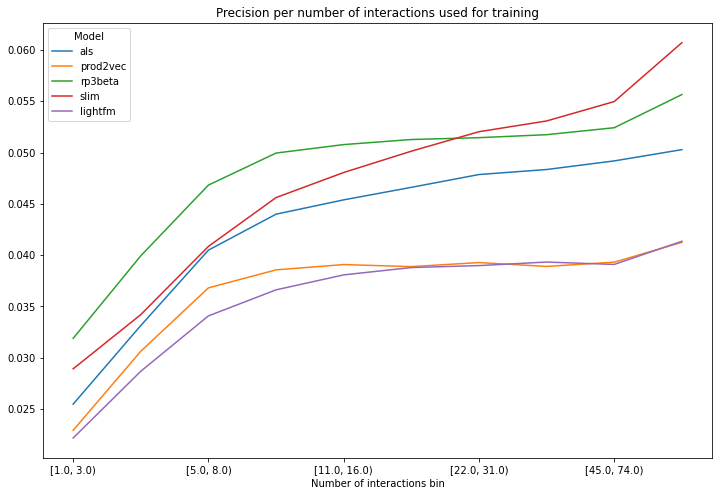

In [12]:
MODELS_TO_PLOT=["als", "prod2vec", "rp3beta", "slim", "lightfm"]

result[MODELS_TO_PLOT].plot()
plt.title("Precision per number of interactions used for training")